# ASSIGNMENT 3                                                McGill COMP451 
Student name (ID)
Brennan King (260953180)

- Did you discuss your solution with classmates? (yes/no) Note that you are allowed to discuss your solutions with classmates. However, you should not copy their answers. After discussion you should answer based on your own understanding.
ANSWER: No

- If yes, please list their names here: 
ANSWER: No

- Did you use LLMs such as chatGPT in finding a solution to any of the problems below? (yes/no) Note that you can use LLMs to get **help** in solving these problems. For your own learning, I recommend that you try to solve each problem yourself, and if you are stuck ask and LLM for a hint, or even better talk to your friend or your TAs for a hint. **You should not copy and paste any answer from an LLM**.
ANSWER: yes

- If yes, explain in 3-4 sentences to what extent and for what purpose you used them. 
ANSWER: I am not very good with matplotlib, but I thought that it would be helpful to have a visualization to see how the accuracy is affected by the value of k. So I used chatGPT to help me print the plot for this.


In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
from IPython.core.debugger import set_trace #this is used for debugging
np.random.seed(1234) 

## Problem 1. kNN (4 pts)

### 1a) Weighted kNN Classification (2pts)
In this assignment we want to implement a variation of kNN where we weight the classification vote of each point by the inverse of their distance to the test point. Fill in the code below to complete the implementation. To avoid numerical issues when distances go to zero, use a small `epsilon` if necessary.

In [4]:
#define the metric we will use to measure similarity
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class WeightedKNN:

    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K #radius
        return
    
    def fit(self, x, y):
        self.x = x #store the training data using this method as it is a lazy learner
        self.y = y
        self.C = np.max(y) + 1 #number of classes
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        n_test = x_test.shape[0]
        #next calculate the distance between every pair of training and test points (why?)
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:]) # n_test x n_train
        knns = np.zeros((n_test, self.K), dtype=int) # index of k nearest neighbours to each test point
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((n_test, self.C))
        # YOUR CODE HERE >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
        # This code is based on the code found in teh KNN notebook provided to us by the prof
        for i in range(n_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
        #simply divide by K to get a probability distribution
        y_prob /= self.K
        # YOUR CODE HERE <<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 
        return y_prob, knns

### 1.b.) classifying faces (2pts)
Next we use this method to classify face images. We use the *Olivetti face dataset*. The dataset contains 400 images of 40 people -- that is we have 10 images for each person. Each image is `64x64` and single channel (grayscale). Let us visualize some examples from the dataset.

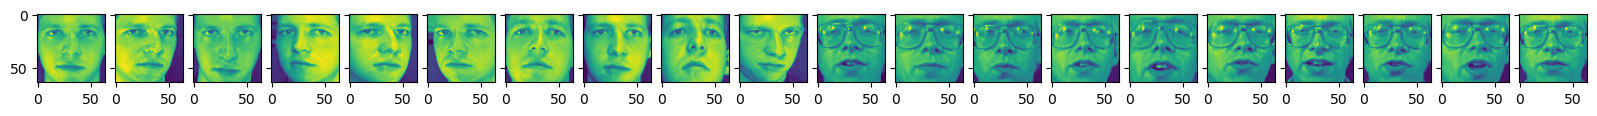

In [6]:
from sklearn import datasets 
from mpl_toolkits.axes_grid1 import ImageGrid                         #To plot the images in grid and we have seen it befoer 

x,y = datasets.fetch_olivetti_faces(return_X_y=True)
def plot_images(data):
    num_plots = data.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    for i in range(num_plots):
        grid[i].imshow(data[i].reshape((64,64)))
    plt.show()
plot_images(x[:20]) 

Below, we plot the 10 nearest neighbours to the first face image above. We see that a few of closest neighbours can be used to classify the face image.

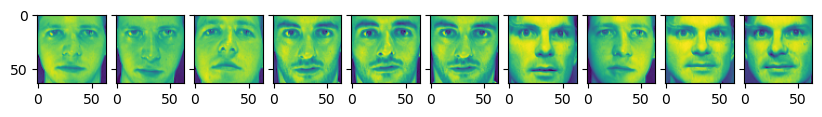

In [8]:
_, neighbours = WeightedKNN(K=10).fit(x,y).predict(x[[0]])
plot_images(x[neighbours[0]])

Shuffle the dataset and use 20% of the data for validation. Report the best hyper-parameter `K` using the validation set. You can use helper functions from `scikit-learn`.

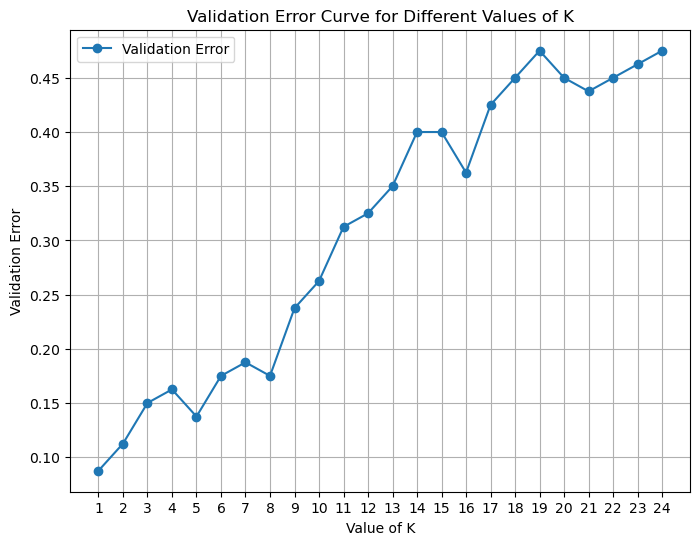

best validation accuracy is 91.25 percent, using k=1


In [10]:
# YOUR CODE HERE >>>>>>>>>>>>>>>>>>>>>>>
from sklearn.model_selection import train_test_split

# Shuffle and split the dataset so that 20% of the data is in the validation set
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Hyperparameter testing for k
best_acc = 0
best_k = None
k_range = range(1, 25)  # Try different values of k to see what's up
errors = []  # To store validation errors so that I can print it out

# Again, this code is heavily borrowing from KNN.ipynb that the prof gave us
for k in k_range:
    model = WeightedKNN(K=k)
    y_prob, knns = model.fit(x_train, y_train).predict(x_val)
    y_pred = np.argmax(y_prob,axis=-1)
    acc = np.sum(y_pred == y_val)/y_val.shape[0]
    errors.append(1 - acc)  # Validation error = 1 - accuracy

    # Update the best accuracy and the k at which it occured (if applicable)
    if acc > best_acc:
        best_acc = acc
        best_k = k

# I have included a plot of the validation error for each of the values of k that I tested
# This helps to visualize how k is affecting the performance of WeightedKNN
plt.figure(figsize=(8, 6))
plt.plot(k_range, errors, marker='o', label='Validation Error')
plt.xlabel('Value of K')
plt.ylabel('Validation Error')
plt.title('Validation Error Curve for Different Values of K')
plt.xticks(k_range)
plt.grid(True)
plt.legend()
plt.show()

# YOUR CODE HERE <<<<<<<<<<<<<<<<<<<<<<<<
print(f'best validation accuracy is {best_acc*100} percent, using k={best_k}')

## Problem 2. Principal Component Analysis (6 pts)

### 2.a.) Eigenfaces (2)
For this assignment, we will find the principle compomponents of the face dataset, these are the eigenvectors of the covariance matrix, and sometimes called *eigenfaces* for face datasets.
Perform PCA and plot the first 20 eigenfaces. To do PCA you can either use the method discussed in the class (i.e., find the eigenvectors of the covariance matrix), or use the method explained in bonus slides, which uses Singular Value Decomposition (SVD), and is more stable. 

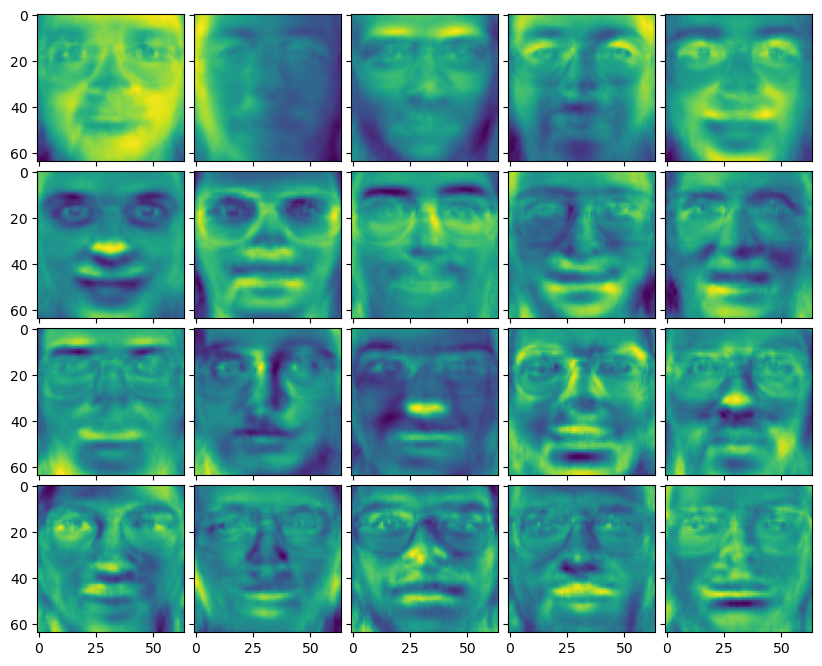

In [12]:
# YOUR CODE HERE >>>>>>>>>>>>>>>

# I'm using the SVD approach that is shown in the PCA jupyter notebook provided by the prof

# Obtaining the face data
x_faces,_ = datasets.fetch_olivetti_faces(return_X_y=True)
num_faces = x_faces.shape[0]
img_height, img_width = 64, 64
x_faces_flattened = x_faces.reshape(num_faces, -1)

# numpy SVD function U is left singular vectors, VT is right singular vectors
# and S is diagonal with eigenvalues
U, S, VT = np.linalg.svd(x_faces_flattened - np.mean(x_faces_flattened, axis=0))
num_eigenfaces = 20
eigenfaces = VT[:num_eigenfaces].reshape((num_eigenfaces, img_height, img_width))

# 4x5 grid of faces
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 5), axes_pad=0.1)

# Using subplots to show the faces in a grid
for ax, eigenface in zip(grid, eigenfaces):
    ax.imshow(eigenface)
plt.show()

# YOUR CODE HERE <<<<<<<<<<<<<<

### 2.b) Picking the number of principal components (2 pts)
Plot the total amount variance explained versus the number of principal components.
Exactly how many principal components are needed to explain 95% of the variance in the data?

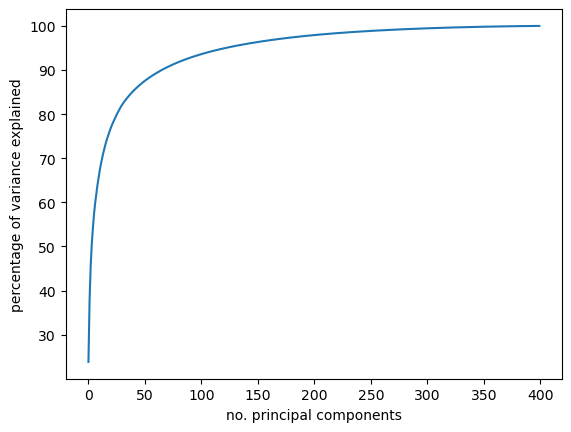

95% of the variance is explained using 123 principal components


In [14]:
# YOUR CODE HERE >>>>>>>>>>>>>>>>>
total_variance = np.sum(S**2)  # Total variance is the sum of squared singular values
var_explained = np.cumsum(S**2) / total_variance * 100  # Counting the amount of variance that is explained by the principle components

# Determine the number of components needed to explain 95% of the variance
# 0 indexed so have to add 1
L = np.argmax(var_explained >= 95) + 1

# YOUR CODE HERE
plt.plot(var_explained)
plt.xlabel("no. principal components")
plt.ylabel("percentage of variance explained")
plt.show()
print(f'95% of the variance is explained using {L} principal components')

### 2.C) Classification using embeddings (2pts)
Use the `WeightedKNN` of previous question to do classification in the embedding space of PCA. Use 100 principal components, and optimize for the choice of K in the range $K \in \{1,\ldots,10\}$. 
This means instead of storing the entire data, we can store its compressed form as vectors of length 100, while maintaining the accuracy. Note that the portion of the code that performs hyper-parameter tuning is identical to what you have above.

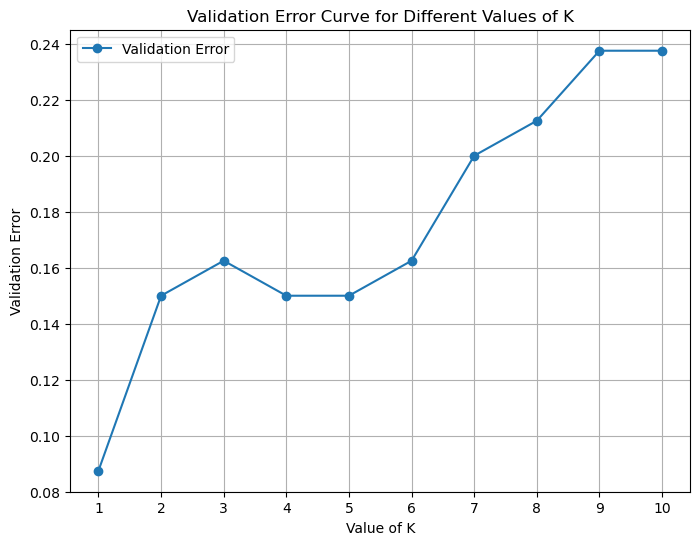

best validation accuracy is 91.25 percent, using k=1


In [16]:
# YOUR CODE HERE >>>>>>>>>>>>>>>>>>>>

# I need to embed the dataset into a lower dimensional space using 100 principal components
# Then I can check the errrors and tune the hyperparameter k as I did in part 1.

# Obtaining the data and centering it
x,y = datasets.fetch_olivetti_faces(return_X_y=True)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_train_centered = x_train - np.mean(x_train, axis=0)
x_val_centered = x_val - np.mean(x_train, axis=0)

# Compute SVD as done above
U, S, VT = np.linalg.svd(x_train_centered, full_matrices=False)

# Selecting the 100 principal components
num_components = 100
pcs = VT[:num_components]
# Project the data onto the top 100 principal components
# i.e. Moving to the embedding space (lower dimension)
x_train_pca = x_train_centered @ pcs.T
x_val_pca = x_val_centered @ pcs.T

# Optimize K using the validation set
k_range = range(1, 11)  # Define the range of K values
best_k = None
best_acc = 0
new_errors = []  # To store validation errors so that I can print it out

for k in k_range:
    model = WeightedKNN(K=k)
    y_prob, knns = model.fit(x_train_pca, y_train).predict(x_val_pca)
    y_pred = np.argmax(y_prob,axis=-1)
    acc = np.sum(y_pred == y_val)/y_val.shape[0]
    new_errors.append(1 - acc)  # Validation error = 1 - accuracy

    # Update the best accuracy and the k at which it occured (if applicable)
    if acc > best_acc:
        best_acc = acc
        best_k = k

# Plot the validation error curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, new_errors, marker='o', label='Validation Error')
plt.xlabel('Value of K')
plt.ylabel('Validation Error')
plt.title('Validation Error Curve for Different Values of K')
plt.xticks(k_range)
plt.grid(True)
plt.legend()
plt.show()

# NOTES: It's cool to see that the first 100 principal components can describe the data well
# enough that we get the same validation accuracy and k value, when doing the hyperparameter
# tuning here, as we did when using the full scale images as input to the WeightedKNN model.

# YOUR CODE HERE <<<<<<<<<<<<<<<<<<
print(f'best validation accuracy is {best_acc*100} percent, using k={best_k}')

## 3) K-Means clustering (2.5 pts) Solution provided
Use the `KMeans` class from `scikit-learn` to cluster the data into K=40 clusters. Use other default values in the `scikit-learn` implementation. Plot the images for 5 out of 40 clusters. Note that this is not a question but an example of application of clustering, provided for demonstration.

C:\Users\Acer\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


cluster 0


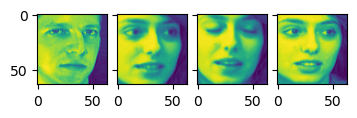

cluster 1


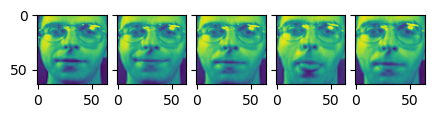

cluster 2


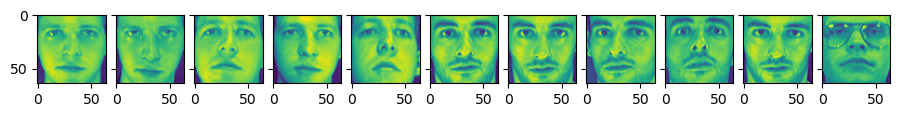

cluster 3


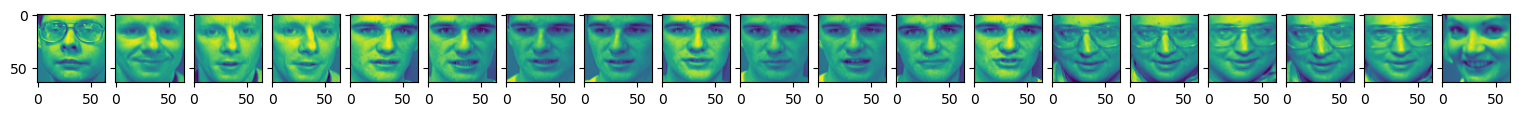

cluster 4


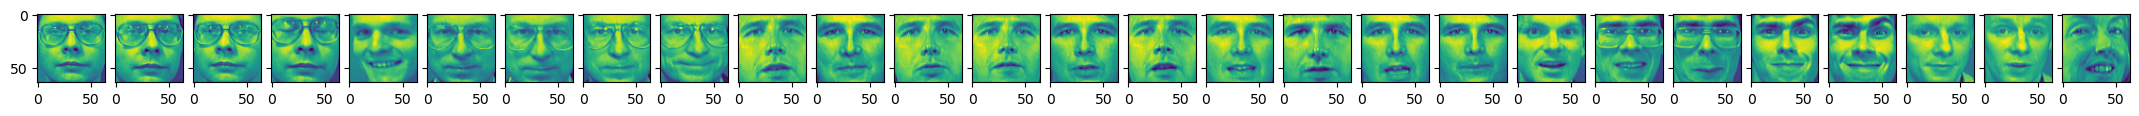

In [18]:
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=40).fit(x)
y_cluster = kmeans.predict(x)
for c in range(5):
    print(f'cluster {c}')
    plot_images(x[y_cluster == c])
